In [24]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.layers import Layer, Dropout, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError





In [25]:
data = pd.read_excel("1390_train_data.xlsx")
df = pd.DataFrame(data)
data.head()

,Additive concentration,MAI,FAI,CsI,CsBr,MABr,MACl,PbI2,PbBr2,PbCl2,...,DMF,DMSO,GBL,Polarity index,Annealing,Etl,Htl,Back contact,Interlayer,PCE (%)
0,0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.8,0.2,0.0,2.7,1.0,6,8,1,2,5.200
1,0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.8,0.2,0.0,2.7,1.0,6,8,1,2,4.828
2,0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.8,0.2,0.0,2.7,1.0,6,8,1,2,4.836
3,0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.8,0.2,0.0,2.7,1.0,6,8,1,2,5.070
4,0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.8,0.2,0.0,2.7,1.0,6,8,1,2,4.980


In [26]:
print(df.isnull().sum())

Additive concentration    0
MAI                       0
FAI                       0
CsI                       0
CsBr                      0
MABr                      0
MACl                      0
PbI2                      0
PbBr2                     0
PbCl2                     0
SnI2                      0
SnCl2                     0
SnBr2                     0
Pb(SCN)2                  0
SnF2                      0
DMF                       0
DMSO                      0
GBL                       0
Polarity index            0
Annealing                 0
Etl                       0
Htl                       0
Back contact              0
Interlayer                0
PCE (%)                   0
dtype: int64


In [27]:
X = df.drop(['PCE (%)'], axis= 1)
y = df['PCE (%)']
print(X.shape, y.shape)

(1390, 24) (1390,)


In [28]:
data = df

print(data.shape)

(1390, 25)


In [ ]:
class VAEConfig:
    input_dim = 25
    latent_dim = 20
    hidden_dims = [512, 256, 128, 64, 32, 25]
    dropout_rate = 0.2
    batch_size = 32
    epochs = 500
    lr = 0.0001



In [ ]:
# import random
# import os

# seed = 42  

# os.environ['PYTHONHASHSEED'] = str(seed)
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)


In [30]:


class VAEModel(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        """ the call method for the model """
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        x = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)

            reconstruction_loss = MeanSquaredError()(x, reconstruction)
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

class AdvancedSampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

def build_encoder(config):
    inputs = layers.Input(shape=(config.input_dim,))
    x = inputs

    for dim in config.hidden_dims:

        x = layers.Dense(256, activation='selu')(inputs)
        x = layers.Dense(128, activation='selu')(x)
        x = layers.Dense(64, activation='selu')(x)
        x = layers.Dense(32, activation='relu')(x)

        x = BatchNormalization()(x)
        x = Dropout(config.dropout_rate)(x)

    z_mean = layers.Dense(config.latent_dim)(x)
    z_log_var = layers.Dense(config.latent_dim)(x)
    z = AdvancedSampling()([z_mean, z_log_var])

    return models.Model(inputs, [z_mean, z_log_var, z], name='encoder')


def build_decoder(config):
    latent_inputs = layers.Input(shape=(config.latent_dim,))
    x = latent_inputs

    for dim in reversed(config.hidden_dims[:-1]):

        x = layers.Dense(32, activation='relu')(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dense(30, activation='relu')(x)


        x = BatchNormalization()(x)
        x = Dropout(config.dropout_rate)(x)

    outputs = layers.Dense(config.input_dim, activation='swish')(x)

    return models.Model(latent_inputs, outputs, name='decoder')



config = VAEConfig()
encoder = build_encoder(config)
decoder = build_decoder(config)
vae = VAEModel(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(config.lr))


vae = VAEModel(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(config.lr))


X_train = data
vae.fit(X_train, epochs=config.epochs, batch_size=config.batch_size)

Epoch 1/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - kl_loss: 0.1142 - loss: 10.4715 - reconstruction_loss: 10.3573
Epoch 2/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.0028 - loss: 8.6186 - reconstruction_loss: 8.6159  
Epoch 3/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.0701 - loss: 5.3317 - reconstruction_loss: 5.2617
Epoch 4/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.1703 - loss: 3.9669 - reconstruction_loss: 3.7966
Epoch 5/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.1800 - loss: 3.0532 - reconstruction_loss: 2.8731
Epoch 6/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.1723 - loss: 2.3386 - reconstruction_loss: 2.1662
Epoch 7/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.1848 - loss: 2.0330 - reconstruction_loss: 1.8482
Epoch 8/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.1840 - loss: 1.8959 - reconstruction_loss: 1.7119
Epoch 9/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.1815 - loss: 1.8291 

In [31]:
def generate_samples(model, num_samples=1000):
    z_samples = np.random.normal(size=(num_samples, config.latent_dim))
    return model.decoder.predict(z_samples)

In [32]:
generated_samples = generate_samples(vae, num_samples=1000)

print("generated samples:")
print(generated_samples)


print(f"mean: {np.mean(generated_samples, axis=0)}")

print(f"Standard deviation: {np.std(generated_samples, axis=0)}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
generated samples:
[[-1.54494746e-02  4.14793193e-02  6.73933685e-01 ...  1.06492448e+00
   1.86754274e+00  5.49309492e+00]
 [ 2.05745983e+00  3.22727203e-01  5.42273521e-01 ...  1.13138211e+00
   1.60495615e+00  7.14558411e+00]
 [ 3.74781847e-01  6.38452232e-01  7.89952517e-01 ...  8.43026638e-01
   2.49116302e+00  1.83902626e+01]
 ...
 [ 3.05107266e-01  6.63703084e-01  3.80885452e-01 ...  1.37121046e+00
   1.63327312e+00  9.12854958e+00]
 [-7.69971544e-03  6.16536677e-01  3.43756884e-01 ...  1.23208737e+00
   4.28744614e-01  9.74579334e+00]
 [-1.25362396e-01  5.95062733e-01  7.57122040e-01 ...  1.24805756e-01
   3.26627642e-01  2.01866455e+01]]
mean: [ 1.5316288e+00  4.3021554e-01  6.0582960e-01 -1.8175920e-06
 -2.1265555e-02  3.3858180e-02  1.5758889e-02  7.1882838e-01
 -6.6180678e-06 -5.1935371e-03  2.4606615e-01 -3.2810555e-03
 -1.8384239e-05 -3.7452390e-03  1.7741157e-02  6.1033499e-01
  3.3576781e-01 -1.6312562e-05  2.5151596e+00  1.0628126

c:\Users\User\Desktop\codes\variational autoencoder\.vae\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


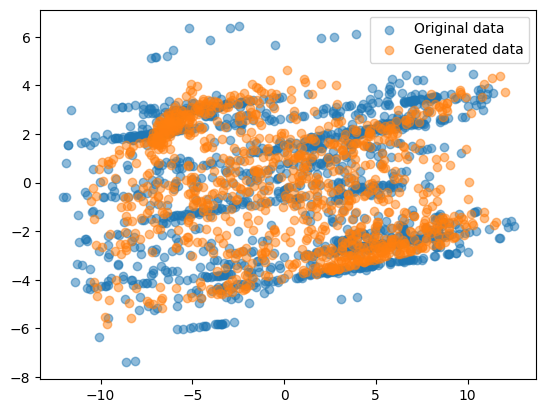

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
original_2d = pca.fit_transform(data)
generated_2d = pca.transform(generated_samples)

plt.scatter(original_2d[:, 0], original_2d[:, 1], label="Original data", alpha=0.5)
plt.scatter(generated_2d[:, 0], generated_2d[:, 1], label="Generated data", alpha=0.5)
plt.legend()
plt.show()